In [1]:
import torch
import torch.nn.functional as F
import requests
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration
import json

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import logging
import pandas as pd
logger = logging.getLogger(__name__)

func_to_enable_grad = '_sample'
setattr(LlavaForConditionalGeneration, func_to_enable_grad, torch.enable_grad(getattr(LlavaForConditionalGeneration, func_to_enable_grad)))

C:\Users\Dreamcore\anaconda3\envs\fyp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open(r"C:\Users\Dreamcore\Downloads\yelp_academic_dataset_review.json\yelp_academic_dataset_review.json", encoding="utf-8") as f:
    data = [json.loads(line) for line in f if line.strip()]

df = pd.DataFrame(data)

In [10]:
len(df)

6990280

In [3]:
sample_df = df[600:700]

In [4]:
# sample_df = pd.read_csv("yelp_csv")

In [5]:
model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    attn_implementation = "eager"
).to(0)

processor = AutoProcessor.from_pretrained(model_id)

if model.language_model.config.model_type == "gemma":
    eos_token_id = processor.tokenizer('<end_of_turn>', add_special_tokens=False).input_ids[0]
else:
    eos_token_id = processor.tokenizer.eos_token_id

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.62it/s]
C:\Users\Dreamcore\anaconda3\envs\fyp\Lib\site-packages\torch\nn\modules\module.py:1355: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  return t.to(
Fetching 2 files: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
preds = []
for index, row in sample_df.iterrows():
    review = row["text"]
    print(review)
    conversation = [
        {
            "role": "system",
            "content": [
                {"type": "text", 
                 "text": """
                    You are a classifier that determines whether a review expresses an overall positive or negative sentiment. 
                    If the text contains sarcasm or mixed sentiment, classify based on the overall final.
                    Read the user's review carefully and respond with exactly one word:\n\n
                    positive — if the overall review approves.\n
                    negative — if the overall review does not approve\n\n
                    Rules:\n
                    • Output only one lowercase word: 'positive' or 'negative'.\n
                    • Do not include punctuation, explanations, or extra text.
                 """}
            ]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"{review}"},
            ]
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(text=prompt, return_tensors='pt').to(0, torch.float16)
    output = model.generate(
        **inputs, 
        max_new_tokens=10, 
        do_sample=False,
        use_cache=True,
        output_attentions=True,
        output_hidden_states=True,
        return_dict_in_generate=True,
        output_scores=True,
        eos_token_id=eos_token_id
    )
    prediction = processor.decode(output.sequences[0], skip_special_tokens=True).split(" ")[-1]
    preds.append(prediction)
    print(prediction)
    print(f"Actual stars: {row['stars']}")
    print("-----------------------------")
    del prompt, inputs, output

Wow. I am not a vegetarian, nor am I a health-food nut (except for my random "diet" binges) but this place is awesome. A co-worker talked me into trying it out one day (by going there and getting me something and putting it in front of me) and she created a monster. I may not order every day but I sure do think about them. And their delicious salads! Every time I go there I am greeted with a smile and there are tons of other people waiting for their food, as well. Good company =)
positive
Actual stars: 5.0
-----------------------------
Only giving a 1 because there is nothing lower!!! Angie
Gave me the worst haircut I've ever had!!! I came in with 2 photos of the cut I wanted came out with my hair looking NOTHING like the photos!!  Even when pointed out to her she didn't not pay attention to what she was doing.  Came out basically having a mans flattop!  Would never go to this place again!!! Nothing like going into the Holidays with a crappie haircut. Thank you!! Angie and Regis Hair s

In [8]:
positive = {1:0, 2:0, 3:0, 4:0, 5:0}
negative = {1:0, 2:0, 3:0, 4:0, 5:0}
above_4_stars_but_labelled_neg = ['UBp0zWyH60Hmw6Fsasei7w',
 'lUUhg8ltDsUZ9h0xnwY4Dg',
 'YcLXh-3UC9y6YFAI9xxzPQ',
 'ra9fNjYUumKp_iaqv-jjDg',
 'k7HWRysS3ICXxzhbddCemw',
 '-pBDXBop_8v1dKk-BBpyzQ',
 'cC79tWLtH1U1n-oi7EozMw',
 'W67uN2nO0Tp22YMoano4JA',
 'dTr-7y6FCf-EUgvAt-XYEQ',
 'tNhXpFVKYXjJx5mipbc_7A',
 'rJ2fUIf-Q7AGx79thOUjMg',
 '4hi2jgnEhwaKfFiZ_Tz4Hw',
 'M4zS53PfEzODW1P2U9JUig',
 '3djwsoWuYzfE8VD3jlNd8Q',
 'TW4DXj74C82qhGjOgnmjyQ',
 't4vzUBVfAPfg7i1EB9Y_6Q',
 'SiazHJtfovy9nwDFfICdwA',
 '0bT9gQpQO6MX3KVv5jrtdg',
 'pIFGqL210EybhN6t0Jtzjw',
 'Sk9DcKI55f0s_253vc50Ig',
 'psxbpQH6lDnBpXli53uxIw',
 '4MsqB18bYyuf0JnDzhKEsg',
 'pPKI8l5FuX3aOHCQAlsfsg',
 'XT_3UpEhO5eJIFxevnv_Yw',
 'Bh1cIMh_mZArniNQoCwZaA',
 'YwwXtjCW2r4tlodyzUfzKA']

for pred, r in zip(preds, sample_df.iterrows()):
    if pred.lower() == "negative":
        if r[1]["stars"] >= 4:
            print("-------------")
            print(r[1]["text"])
            print(f"pred: {pred}")
            print(f"actual star: {r[1]['stars']}")
            print(r[1]["review_id"])
            above_4_stars_but_labelled_neg.append(r[1]["review_id"])
        negative[int(r[1]["stars"])]+=1
    elif pred.lower() == "positive":
        positive[int(r[1]["stars"])]+=1
    else:
        print(f"Unknown pred: {pred}")


-------------
After driving pass all the seafood restaurants around Clearwater Beach, I knew wanted seafood right there and then. I wasn't familiar with the area and did not do any yelping before hand, so was pretty hesitant to just blindly pick a restaurant.  Finally, after a long day at the beach, we made a quick walk across the street to all the restaurants and thats when we stumbled into Crabby Bill's. We ordered the $25 bucket of steamed seafood. It was decent, not necessarily the best fresh seafood. This was just a quick snack that I shared with one other person to keep us going before our big dinner at Bern's Steak House that we had reservation for a couple hours later.
pred: negative
actual star: 4.0
4MsqB18bYyuf0JnDzhKEsg
-------------
My boyfriend and I decided to stop by for lunch yesterday, and I am so glad we did. I ordered a side of beans, chips and salsa, and guacamole. He ordered two steak tacos and a side of rice. The beans are hands down my favorite I've had from a me

In [9]:
positive

{1: 0, 2: 0, 3: 4, 4: 20, 5: 37}

In [10]:
negative

{1: 11, 2: 9, 3: 9, 4: 5, 5: 0}

In [11]:
above_4_stars_but_labelled_neg

['UBp0zWyH60Hmw6Fsasei7w',
 'lUUhg8ltDsUZ9h0xnwY4Dg',
 'YcLXh-3UC9y6YFAI9xxzPQ',
 'ra9fNjYUumKp_iaqv-jjDg',
 'k7HWRysS3ICXxzhbddCemw',
 '-pBDXBop_8v1dKk-BBpyzQ',
 'cC79tWLtH1U1n-oi7EozMw',
 'W67uN2nO0Tp22YMoano4JA',
 'dTr-7y6FCf-EUgvAt-XYEQ',
 'tNhXpFVKYXjJx5mipbc_7A',
 'rJ2fUIf-Q7AGx79thOUjMg',
 '4hi2jgnEhwaKfFiZ_Tz4Hw',
 'M4zS53PfEzODW1P2U9JUig',
 '3djwsoWuYzfE8VD3jlNd8Q',
 'TW4DXj74C82qhGjOgnmjyQ',
 't4vzUBVfAPfg7i1EB9Y_6Q',
 'SiazHJtfovy9nwDFfICdwA',
 '0bT9gQpQO6MX3KVv5jrtdg',
 'pIFGqL210EybhN6t0Jtzjw',
 'Sk9DcKI55f0s_253vc50Ig',
 'psxbpQH6lDnBpXli53uxIw',
 '4MsqB18bYyuf0JnDzhKEsg',
 'pPKI8l5FuX3aOHCQAlsfsg',
 'XT_3UpEhO5eJIFxevnv_Yw',
 'Bh1cIMh_mZArniNQoCwZaA',
 'YwwXtjCW2r4tlodyzUfzKA']

In [12]:
above_4_stars_but_labelled_neg

['UBp0zWyH60Hmw6Fsasei7w',
 'lUUhg8ltDsUZ9h0xnwY4Dg',
 'YcLXh-3UC9y6YFAI9xxzPQ',
 'ra9fNjYUumKp_iaqv-jjDg',
 'k7HWRysS3ICXxzhbddCemw',
 '-pBDXBop_8v1dKk-BBpyzQ',
 'cC79tWLtH1U1n-oi7EozMw',
 'W67uN2nO0Tp22YMoano4JA',
 'dTr-7y6FCf-EUgvAt-XYEQ',
 'tNhXpFVKYXjJx5mipbc_7A',
 'rJ2fUIf-Q7AGx79thOUjMg',
 '4hi2jgnEhwaKfFiZ_Tz4Hw',
 'M4zS53PfEzODW1P2U9JUig',
 '3djwsoWuYzfE8VD3jlNd8Q',
 'TW4DXj74C82qhGjOgnmjyQ',
 't4vzUBVfAPfg7i1EB9Y_6Q',
 'SiazHJtfovy9nwDFfICdwA',
 '0bT9gQpQO6MX3KVv5jrtdg',
 'pIFGqL210EybhN6t0Jtzjw',
 'Sk9DcKI55f0s_253vc50Ig',
 'psxbpQH6lDnBpXli53uxIw',
 '4MsqB18bYyuf0JnDzhKEsg',
 'pPKI8l5FuX3aOHCQAlsfsg',
 'XT_3UpEhO5eJIFxevnv_Yw',
 'Bh1cIMh_mZArniNQoCwZaA',
 'YwwXtjCW2r4tlodyzUfzKA']

In [13]:
above_4_stars_but_labelled_neg

['UBp0zWyH60Hmw6Fsasei7w',
 'lUUhg8ltDsUZ9h0xnwY4Dg',
 'YcLXh-3UC9y6YFAI9xxzPQ',
 'ra9fNjYUumKp_iaqv-jjDg',
 'k7HWRysS3ICXxzhbddCemw',
 '-pBDXBop_8v1dKk-BBpyzQ',
 'cC79tWLtH1U1n-oi7EozMw',
 'W67uN2nO0Tp22YMoano4JA',
 'dTr-7y6FCf-EUgvAt-XYEQ',
 'tNhXpFVKYXjJx5mipbc_7A',
 'rJ2fUIf-Q7AGx79thOUjMg',
 '4hi2jgnEhwaKfFiZ_Tz4Hw',
 'M4zS53PfEzODW1P2U9JUig',
 '3djwsoWuYzfE8VD3jlNd8Q',
 'TW4DXj74C82qhGjOgnmjyQ',
 't4vzUBVfAPfg7i1EB9Y_6Q',
 'SiazHJtfovy9nwDFfICdwA',
 '0bT9gQpQO6MX3KVv5jrtdg',
 'pIFGqL210EybhN6t0Jtzjw',
 'Sk9DcKI55f0s_253vc50Ig',
 'psxbpQH6lDnBpXli53uxIw',
 '4MsqB18bYyuf0JnDzhKEsg',
 'pPKI8l5FuX3aOHCQAlsfsg',
 'XT_3UpEhO5eJIFxevnv_Yw',
 'Bh1cIMh_mZArniNQoCwZaA',
 'YwwXtjCW2r4tlodyzUfzKA']

In [15]:
df_above_4 = df[df["stars"]>=4][:5000]
df_below_2 = df[df["stars"]<=2][:5000]

In [18]:
df_below_2

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
29,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
41,RB8UpF_kT2xoOC51OzXEeA,EZjT2qJN0mOXypMAqZdSrQ,A2q7d-CBM2-81tVkmS4JMw,2.0,1,1,0,"Straight to the point, it's cheap, it tastes a...",2017-07-08 18:58:42
46,Ki90-hauSIfW_7sBuBBqfA,Z2cOL3n9V8NoguJ-uU_Nvw,j8JOZvfeHEfUWq3gEz6ABQ,2.0,2,3,0,NEVER AGAIN. This is a so called restaurant th...,2014-06-11 14:55:14
47,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12
...,...,...,...,...,...,...,...,...,...
26864,FIUhbkZ4KU55OFweuqRRag,k2lUN5F_idC33XrglX6rWg,xwKYBPO0ByGlkvNcr8FdqQ,2.0,1,1,0,"We had a group of eleven and were told, that t...",2017-06-30 15:05:39
26874,0_w2MRmCumFAhI5Yqr1Q0A,anZc7V2ufAsPaMA4ovW2fA,gK9CdFaCXmHoW8aLfXiSqg,2.0,2,4,0,Beer: Excellent. The only reason to go here. H...,2016-07-27 20:27:36
26878,de13jgmObjhswMJUFePDsQ,ilDrcEgZjala4y_-jj3ejw,5xokROlB8Zo5T-_qbHzsrQ,1.0,0,1,0,"This could be an entirely pointless review, bu...",2014-07-29 22:11:14
26879,PAY0fTue8gsApdvelsBKiQ,-EvcVRYcye_zoPmlMruZLA,edO1Rej_-_I4vPSVYIZ5NQ,1.0,3,0,0,Here is the massive problem with this joint - ...,2012-08-19 00:47:01


# Testing on IMDB

In [2]:
df = pd.read_csv(r"C:\Users\Dreamcore\Downloads\archive\IMDB Dataset.csv")
sample_df = df[250:350]
sample_df

,review,sentiment
250,"Supposedly a ""social commentary"" on racism and...",negative
251,"OK, I bought this film from Woolworths for my ...",negative
252,Insignificant and low-brained (haha!) 80's hor...,negative
253,Does anyone remember the alternative comedy sh...,negative
254,"Well, here's another terrific example of awkwa...",positive
...,...,...
345,Incomprehensibly dreadful mishmash of the prob...,negative
346,Did anyone edit this film? Or was it only the ...,negative
347,"Riding high on the success of ""Rebel Without a...",positive
348,Most of the comments on this movie are positiv...,negative


In [3]:
from peft import PeftModel

model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    attn_implementation = "eager"
).to(0)

processor = AutoProcessor.from_pretrained(model_id)

if model.language_model.config.model_type == "gemma":
    eos_token_id = processor.tokenizer('<end_of_turn>', add_special_tokens=False).input_ids[0]
else:
    eos_token_id = processor.tokenizer.eos_token_id

# path where you saved LoRA adapters after training
lora_weights_path = r"llava-hf/llava-1.5-7b-hf-fine_tuned_on_yelp/checkpoint-32"

# attach LoRA adapters
model = PeftModel.from_pretrained(model, lora_weights_path)

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.98it/s]
C:\Users\Dreamcore\anaconda3\envs\fyp\Lib\site-packages\torch\nn\modules\module.py:1355: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  return t.to(
Fetching 2 files: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
preds = []
i = 1
for index, row in sample_df.iterrows():
    print(i)
    i += 1
    review = row["review"]
    print(review)
    conversation = [
        {
            "role": "system",
            "content": [
                {"type": "text", 
                 "text": """
                    You are a classifier that determines whether a review expresses an overall positive or negative sentiment. 
                    Read the user's review carefully and respond with exactly one word:\n\n
                    positive — if the overall review approves.\n
                    negative — if the overall review does not approve\n\n
                    Rules:\n
                    • Output only one lowercase word: 'positive' or 'negative'.\n
                    • Do not include punctuation, explanations, or extra text.
                 """}
            ]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"{review}"},
            ]
        },
    ]
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    inputs = processor(text=prompt, return_tensors='pt').to(0, torch.float16)
    output = model.generate(
        **inputs, 
        max_new_tokens=10, 
        do_sample=False,
        use_cache=True,
        output_attentions=True,
        output_hidden_states=True,
        return_dict_in_generate=True,
        output_scores=True,
        eos_token_id=eos_token_id
    )
    prediction = processor.decode(output.sequences[0], skip_special_tokens=True).split(" ")[-1]
    preds.append(prediction)
    print(prediction)
    print(f"Actual sentiment: {row['sentiment']}")
    print("-----------------------------")
    del prompt, inputs, output

1
Supposedly a "social commentary" on racism and prison conditions in the rural South of the 1970's, "Nightmare" is full of bad Southern stereotypes, complete with phoney accents. Not only would it be offensive to the sensibilities of most American Southerners, this tawdry piece of work comes off as just a thinly-disguised "babe in prison" movie--especially in its uncut original version. Nevertheless, acting is generally above average and the late Chuck Connors, in particular, does a good job of making viewers hate him--even though he looks somewhat uncomfortable in several scenes. There's also a change-of-pace role for the late Robert Reed, who appears as the lecherous warden, and Tina Louise (previously Ginger of "Gilligan's Island") made a rather believable sadistic prison guard. My grade: D. <br /><br />
negative
Actual sentiment: negative
-----------------------------
2
OK, I bought this film from Woolworths for my friend for a joke present on his birthday, because the front cover

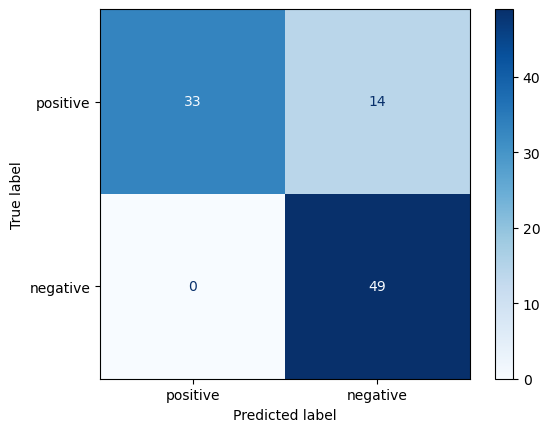

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(sample_df["sentiment"], preds, labels=["positive", "negative"])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["positive", "negative"])
disp.plot(cmap='Blues')

In [13]:
sample_df.to_csv("imdb_sample")